In [9]:
import sys
sys.path.insert(0, 'D:\Pulpit\FaceProject')

In [10]:
# !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

In [11]:
# import bz2
# fromF = bz2.open("shape_predictor_68_face_landmarks.dat.bz2", "rb")
# data = fromF.read()
# toF = open("shape_predictor_68_face_landmarks.dat", "wb")
# toF.write(data)

In [12]:
import helper as h

In [13]:
from imutils import face_utils
from scipy.spatial import Delaunay
from itertools import combinations
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [16]:
babka = cv2.imread('images/kanye.jpg')
babka = cv2.resize(babka, (600,400))
vertices = np.array([(230, 223), (227, 203), (261, 192)], dtype=np.float32)
ja = cv2.imread('images/depp.jpg')
ja = cv2.resize(ja, (600,400))
new_vertices = np.array([(289, 180), (288, 164), (311, 151)], dtype=np.float32)

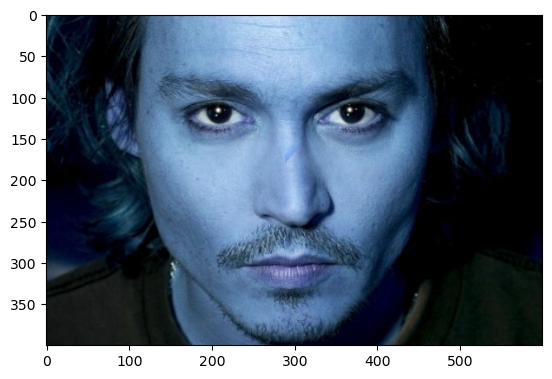

In [17]:
x = h.mapT2T(babka, ja, vertices, new_vertices)
plt.imshow(x)

In [18]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

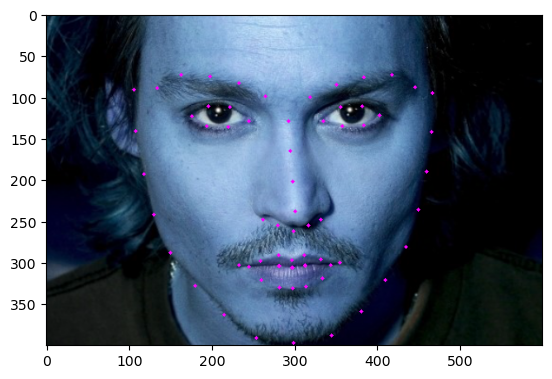

In [19]:
babkaCoords = h.drawCoords(ja)
plt.imshow(babkaCoords)

In [20]:
INDICES = h.fileToNumpy('trianglesIndices.txt')

In [21]:
INDICES.shape

(113, 3)

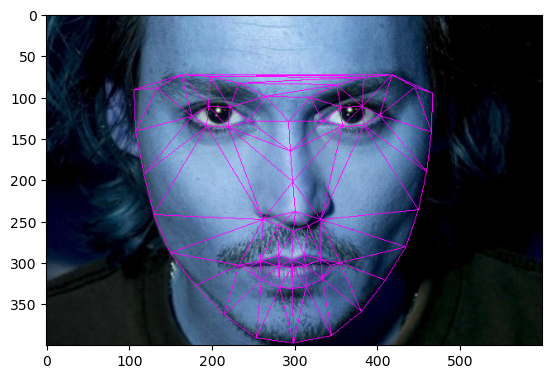

In [22]:
x = h.drawLines(ja)
plt.imshow(x)

In [23]:
indices, src_coords = h.getTrianglesCoords(babka, None)
_, dest_coords = h.getTrianglesCoords(ja, indices)

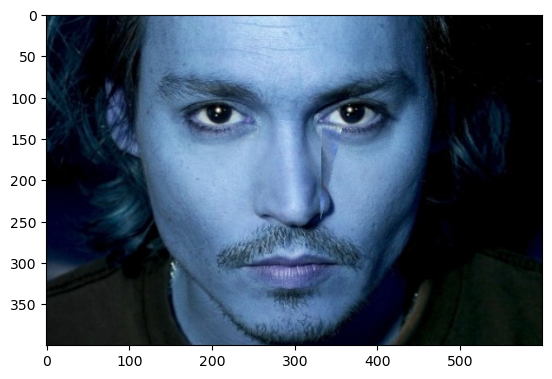

In [24]:
x = h.mapT2T(babka, ja, src_coords[10], dest_coords[10])
plt.imshow(x)

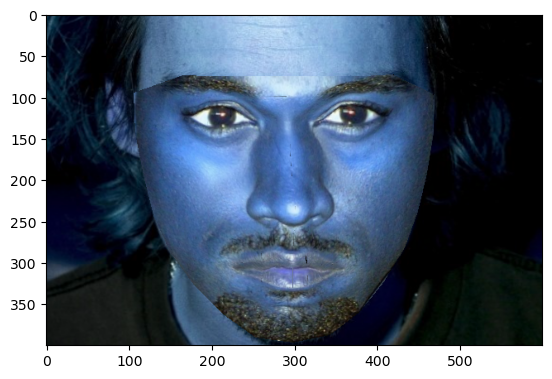

In [25]:
x = h.swapAll(babka, ja, src_coords, dest_coords)
plt.imshow(x)

In [26]:
# cap = cv2.VideoCapture(0)
 
# while True:
#     _, image = cap.read()
#     _, dest_coords = h.getTrianglesCoords(image, trianglesIndices=indices)
#     if type(dest_coords) != type(None):
#         x = h.swapAll(babka, image, src_coords, dest_coords)
#     else:
#         x = image

#     cv2.imshow("Output1", x)    
    
#     #close on Esc
#     k = cv2.waitKey(5) & 0xFF
#     if k == 27:
#         break

# cv2.destroyAllWindows()
# cap.release()

In [78]:
from typing import Callable
from PIL import Image
import imutils

In [100]:
class Face:

    def __init__(self, img: np.array = None, 
                 indices: np.array = INDICES,
                 detector: Callable[[np.array], np.array] = detector, 
                 predictor: Callable[[np.array], np.array] = predictor) -> None:

        self.indices = indices

        self.tris_coords = None
        self.tris_coords_min = None
        self.tris_bboxes = None
        self.tris_image_parts = None

        self.trans_tris_coords = None
        self.trans_tris_coords_min = None
        self.trans_tris_bboxes = None
        self.trans_tris_image_parts = None
        self.trans_masks = None

        if not self._empty_face(img):
            img = cv2.resize(img, (600,400))

            rectangle = self._init_rectangle(img, detector)

            self.tris_coords = self._init_tris_coords(img, rectangle, predictor)
            self.tris_coords_min = self.minimize_coords(self.tris_coords)
            self.tris_bboxes = self.get_bboxes(self.tris_coords)
            self.tris_image_parts = self.get_image_parts(image=img)

            self.transform(self.tris_coords)

    def _empty_face(self, img):
        if type(img) == type(None): 
            return True
        return False
    
    def _init_rectangle(self, image, detector) -> np.array:
        rectangles = detector(image, 0)
        try:
            assert len(rectangles) == 1
        except:
            raise AssertionError(f'faces: {len(rectangles)}, expected 1')

        return rectangles[0]

    def _init_tris_coords(self, image, rectangle, predictor) -> np.array:
        predictions = predictor(image, rectangle)
        predictions = face_utils.shape_to_np(predictions)
        return predictions[self.indices]
    
    def get_bboxes(self, tris_coords) -> np.array:
        bboxes = []
        for triangle in tris_coords:
            bboxes.append(np.array(cv2.boundingRect(triangle)))
        return np.array(bboxes)
    
    def get_image_parts(self, image) -> list:
        images = []
        for bbox in self.tris_bboxes:
            x, y, w, h = bbox
            images.append(
                image[y:y+h, x:x+w]
            )
        return images
    
    def minimize_coords(self, tris_coords) -> np.array:

        def minimize(array):            
            min = array.min()
            return array-min

        coords = tris_coords.copy()
        coords = np.apply_along_axis(minimize, 1, coords)
        return coords
    
    def transform(self, dest_coords) -> None:
        self.trans_tris_coords = dest_coords
        self.trans_tris_coords_min = self.minimize_coords(self.trans_tris_coords)
        self.trans_tris_bboxes = self.get_bboxes(self.trans_tris_coords)

        parts = []      
        masks = []  
        for idx, (src, dest) in enumerate(zip(self.tris_coords_min.astype(np.float32), 
                            self.trans_tris_coords_min.astype(np.float32))):
            
            M = cv2.getAffineTransform(src, dest)
            x, y, w, h = self.trans_tris_bboxes[idx]
            part = cv2.warpAffine(self.tris_image_parts[idx], M, (w, h))
            parts.append(part)
            mask = np.zeros((h, w), dtype=np.uint8)
            cv2.fillConvexPoly(mask, dest.astype(int), (1))
            masks.append(mask)

        self.trans_tris_image_parts = parts
        self.trans_masks = masks

In [101]:
depp = np.array(Image.open('images/depp.jpg'))
depp = Face(depp)
kanye = np.array(Image.open('images/kanye.jpg'))
kanye = Face(kanye)

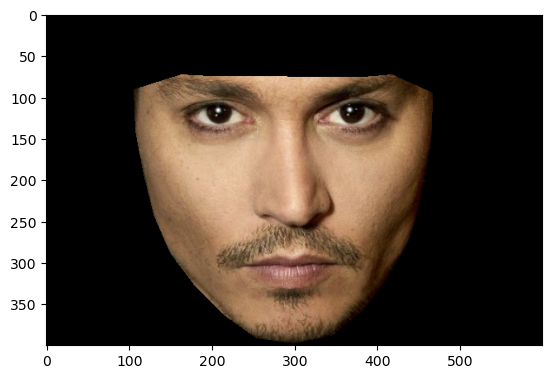

In [102]:
def put_face_on_image(face: Face, image):
    trans_parts = face.trans_tris_image_parts
    trans_bboxes = face.trans_tris_bboxes
    trans_masks = face.trans_masks

    for part, bbox, mask in zip(trans_parts, trans_bboxes, trans_masks):
        x, y, w, h = bbox
        image[y:y+h, x:x+w][mask != 0] = part[mask != 0]

    return image

img = put_face_on_image(depp, np.zeros((400, 600, 3), dtype=np.uint8))
plt.imshow(img)

In [103]:
def _check_faces(faces):
    if faces.__class__.__name__ != 'list': 
        raise TypeError(f'faces should be a \'list\', but the user provided \'{faces.__class__.__name__}\'.')
    
    if len(faces) < 2:
        raise ValueError(f'faces should contain at least 2 Face objects, but the user provided {len(faces)}.')
    
    for i,face in enumerate(faces):
        if face.__class__.__name__ != 'Face':
            raise TypeError(f'faces should contain only \'Face\' type, but there is \'{face.__class__.__name__}\' type at {i} index.')

In [104]:
def _check_weights(faces, weights):
    if weights.__class__.__name__ != 'list': 
        raise TypeError(f'weights should be a \'list\', but the user provided \'{weights.__class__.__name__}\'.')
    
    if len(weights) != len(faces):
        raise ValueError(f'weights should be of the same lenght as faces, but len(faces)={len(faces)} and len(weights)={len(weights)}')
    
    for i,weight in enumerate(weights):
        if weight.__class__.__name__ not in ['float', 'int']:
            raise TypeError(f'faces should contain only \'floats\' or \'ints\', but there is \'{weight.__class__.__name__}\' type at {i} index.')
        

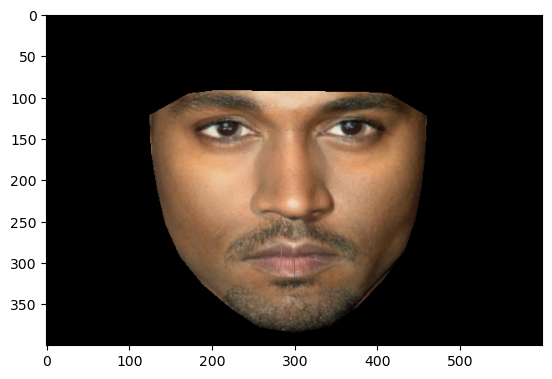

In [105]:
def combine_faces(faces: list[Face], weights: list[float] = [None], new_coords: np.array = None) -> Face:

    #check args
    _check_faces(faces)

    #initialize equal weights if None
    if weights[0] == None:
        weights = [1/len(faces)] * len(faces)
    
    # check args
    _check_weights(faces, weights)
    
    #normalize weights
    weights = np.array(weights) / np.sum(weights)
    
    # create new Face object
    new_face = Face()

    # if there are no face coords provided 
    # they are computed as weighted average
    # of all provede faces coordinates
    if type(new_coords) == type(None):
        new_coords = faces[0].tris_coords * weights[0]

        for face, weight in zip(faces[1:], weights[1:]):
            new_coords += face.tris_coords * weight
        new_coords = np.round(new_coords).astype(np.int32)
    new_face.tris_coords = new_coords

    # transforming all faces to be of shape
    # provided in new_coords variable 
    for face in faces:
        face.transform(new_coords)

    new_face.tris_coords_min = new_face.minimize_coords(new_face.tris_coords)
    new_face.tris_bboxes = new_face.get_bboxes(new_face.tris_coords)

    # combine all provided faces with respect to their weights
    face_parts = []
    for idx_ignore, (face, weight) in enumerate(zip(faces, weights)):
        for idx, part in enumerate(face.trans_tris_image_parts):
            if idx_ignore == 0:
                face_parts.append(part * weight)
            else:
                face_parts[idx] += part*weight

    # change types to uint8 type
    # demanded by opencv warpAffine function
    for idx, part in enumerate(face_parts):
        face_parts[idx] = part.astype(np.uint8)


    new_face.tris_image_parts = face_parts
    new_face.transform(new_face.tris_coords)

    return new_face

new_face = combine_faces(faces=[depp,kanye], weights=[1,1])


img = put_face_on_image(new_face, np.zeros((400, 600, 3), dtype=np.uint8))
plt.imshow(img)


In [106]:
import imageio
from tqdm import tqdm

In [107]:
def face_morphing_video(faces: list[Face], path: str = "face_morphing.gif"):
    _check_faces(faces=faces)

    with imageio.get_writer(path, mode='I') as writer:
        all_weights = np.concatenate([np.linspace(0,1,20), np.linspace(0,1,20)[::-1], np.linspace(0,1,20), np.linspace(0,1,20)[::-1]])
        for idx, weight in enumerate(all_weights):
            weights = [float(weight), 1]
            if idx < len(all_weights) / 4 or idx >= 3 * len(all_weights) / 4:
                weights = [1, float(weight)]

            new_face = combine_faces(faces=faces, weights=weights)
            image = put_face_on_image(new_face, np.zeros((400, 600, 3), dtype=np.uint8))
            writer.append_data(image)

In [108]:
kanye = Face(np.array(Image.open('images/kanye.jpg')))
depp = Face(np.array(Image.open('images/depp.jpg')))

In [109]:
face_morphing_video(faces=[kanye,depp], path='produced_gifs/depp&kanye.gif')

In [110]:
tata = Face(np.array(Image.open('images/tata.jpg')))
mama = Face(np.array(Image.open('images/mama.jpg')))

In [111]:
face_morphing_video(faces=[tata,mama], path='produced_gifs/tata&mama.gif')